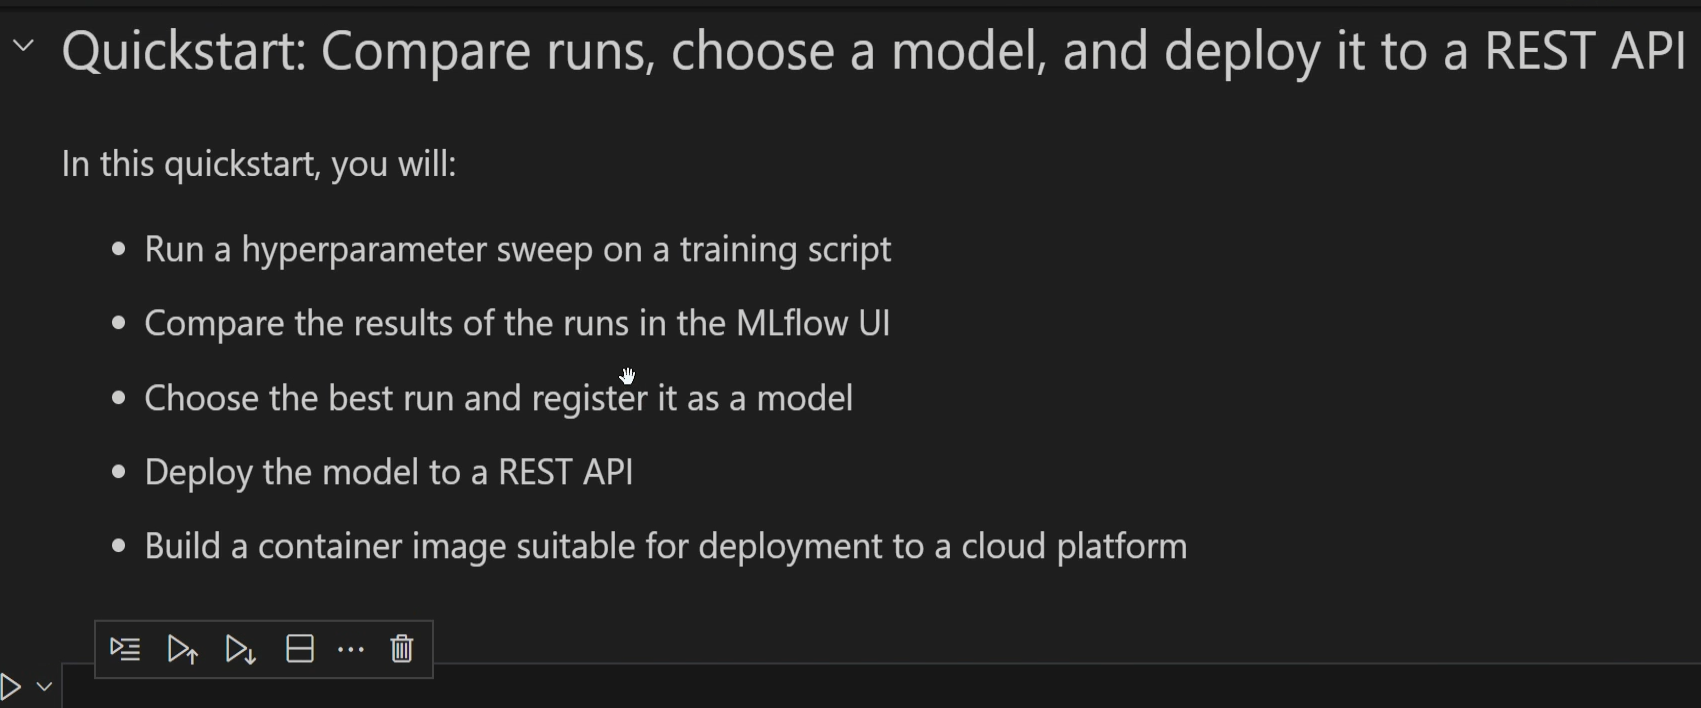

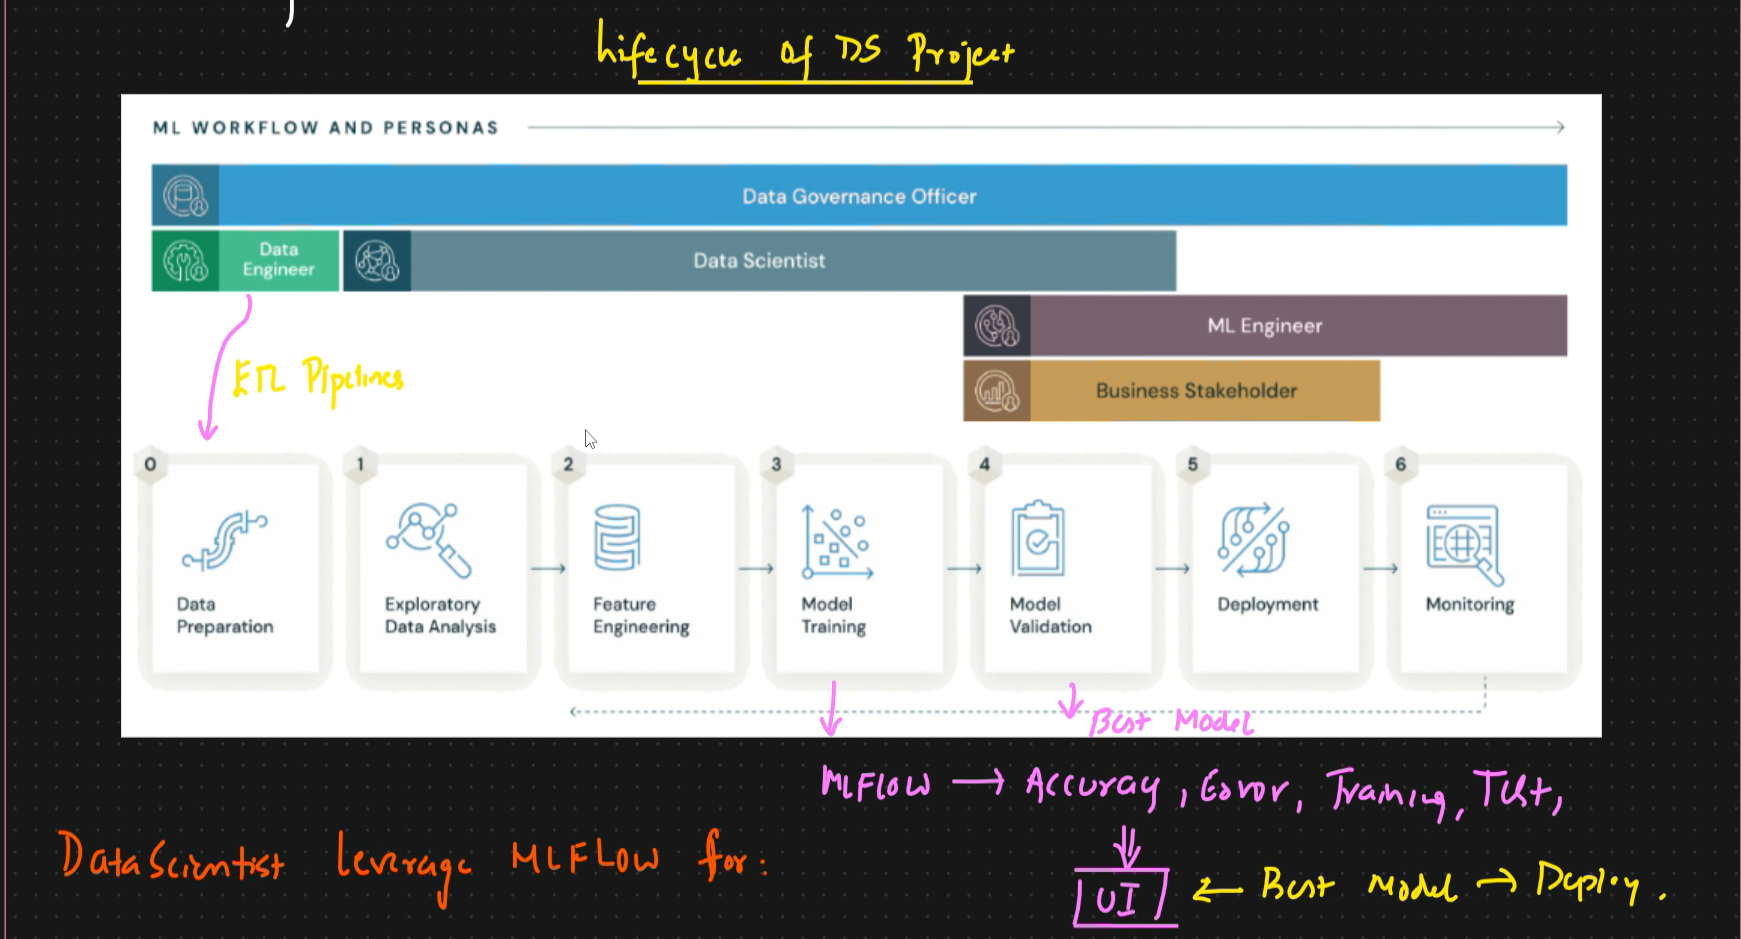


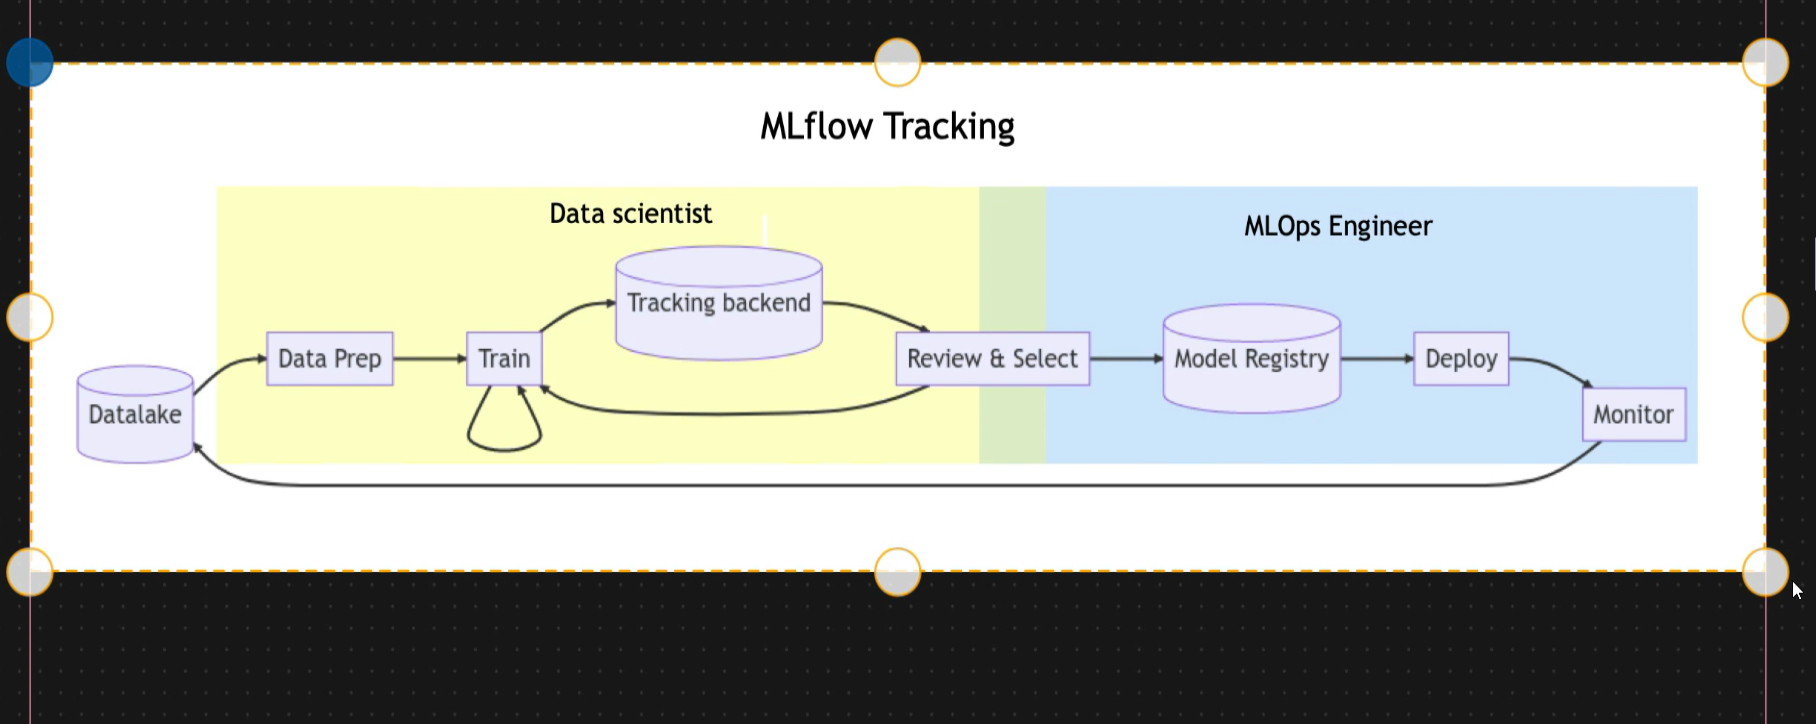

In [101]:
import keras
import numpy as np
import pandas as pd
from hyperopt import STATUS_OK,Trials,fmin,hp,tpe
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature


In [102]:
data = pd.read_csv('https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv',sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [103]:
# Split the train, tesst and validation sets

train,test = train_test_split(data, test_size=0.25, random_state=42)
train


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2835,6.3,0.25,0.22,3.30,0.048,41.0,161.0,0.99256,3.16,0.50,10.5,6
1157,7.8,0.30,0.29,16.85,0.054,23.0,135.0,0.99980,3.16,0.38,9.0,6
744,7.4,0.38,0.27,7.50,0.041,24.0,160.0,0.99535,3.17,0.43,10.0,5
1448,7.4,0.16,0.49,1.20,0.055,18.0,150.0,0.99170,3.23,0.47,11.2,6
3338,7.2,0.27,0.28,15.20,0.046,6.0,41.0,0.99665,3.17,0.39,10.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4426,6.2,0.21,0.52,6.50,0.047,28.0,123.0,0.99418,3.22,0.49,9.9,6
466,7.0,0.14,0.32,9.00,0.039,54.0,141.0,0.99560,3.22,0.43,9.4,6
3092,7.6,0.27,0.52,3.20,0.043,28.0,152.0,0.99129,3.02,0.53,11.4,6
3772,6.3,0.24,0.29,13.70,0.035,53.0,134.0,0.99567,3.17,0.38,10.6,6


In [104]:
train_x = train.drop(['quality'],axis=1)
train_x

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
2835,6.3,0.25,0.22,3.30,0.048,41.0,161.0,0.99256,3.16,0.50,10.5
1157,7.8,0.30,0.29,16.85,0.054,23.0,135.0,0.99980,3.16,0.38,9.0
744,7.4,0.38,0.27,7.50,0.041,24.0,160.0,0.99535,3.17,0.43,10.0
1448,7.4,0.16,0.49,1.20,0.055,18.0,150.0,0.99170,3.23,0.47,11.2
3338,7.2,0.27,0.28,15.20,0.046,6.0,41.0,0.99665,3.17,0.39,10.9
...,...,...,...,...,...,...,...,...,...,...,...
4426,6.2,0.21,0.52,6.50,0.047,28.0,123.0,0.99418,3.22,0.49,9.9
466,7.0,0.14,0.32,9.00,0.039,54.0,141.0,0.99560,3.22,0.43,9.4
3092,7.6,0.27,0.52,3.20,0.043,28.0,152.0,0.99129,3.02,0.53,11.4
3772,6.3,0.24,0.29,13.70,0.035,53.0,134.0,0.99567,3.17,0.38,10.6


In [105]:
train_y = train[['quality']].values # here we are getting 2D array. We need 1D array so we use RAVEL method.
train_y

array([[6],
       [6],
       [5],
       ...,
       [6],
       [6],
       [8]])

In [106]:
train_y = train[['quality']].values.ravel() # Here we will get 1D array
train_y



array([6, 6, 5, ..., 6, 6, 8])

In [107]:
# test dataset
test_x = test.drop(['quality'],axis=1).values
test_y = test[['quality']].values.ravel()

In [108]:
test_x

array([[ 6.        ,  0.29      ,  0.41      , ...,  3.09      ,
         0.59      , 10.96666667],
       [ 5.4       ,  0.53      ,  0.16      , ...,  3.2       ,
         0.53      , 13.2       ],
       [ 7.1       ,  0.25      ,  0.39      , ...,  3.28      ,
         0.43      , 12.2       ],
       ...,
       [ 5.9       ,  0.13      ,  0.28      , ...,  3.43      ,
         0.64      , 10.8       ],
       [ 6.8       ,  0.3       ,  0.29      , ...,  3.03      ,
         0.32      , 12.9       ],
       [ 7.4       ,  0.25      ,  0.36      , ...,  3.19      ,
         0.44      , 10.8       ]])

In [109]:
# Splitting this train data into train and valid datasets
train_x, valid_x, train_y, valid_y = train_test_split(train_x,train_y,test_size=0.20,random_state=42)




## ANN Model

In [114]:
def train_model(params, epochs, train_x, train_y, valid_x, valid_y, test_x, test_y):
    mean = np.mean(train_x, axis=0)
    variance = np.var(train_x, axis=0)

    model = keras.Sequential(
        [
            keras.Input([train_x.shape[1]]),
            keras.layers.Normalization(mean=mean, variance=variance),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1)
        ]
    )

    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=params['lr'], momentum=params['momentum']),
        loss='mse',
        metrics=[keras.metrics.RootMeanSquaredError()]
    )

    # Create signature here for logging inside the run
    sample_input = train_x[:1]
    sample_output = model.predict(sample_input)
    signature = infer_signature(sample_input, sample_output)


    with mlflow.start_run(nested=True):
        model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=epochs, verbose=0, batch_size=64)
        eval_result = model.evaluate(valid_x, valid_y, batch_size=64)
        eval_rmse = eval_result[1]

        for key, value in params.items():
            mlflow.log_param(key, value)
        mlflow.log_metric('eval_rmse', eval_rmse)
        mlflow.tensorflow.log_model(model, 'model', signature=signature)

        return {
            'loss': eval_rmse,
            'status': STATUS_OK,
            'model': model
        }


In [115]:
#define HyperOpt

def objective(params):
    result = train_model(
        params,
        epochs=10,
        train_x=train_x,
        train_y=train_y,
        valid_x=valid_x,
        valid_y=valid_y,
        test_x=test_x,
        test_y=test_y
    )
    return result

In [116]:
space = {
    'lr':hp.loguniform('lr',np.log(1e-5),np.log(1e-1)),
    'momentum':hp.uniform('momentum',0.0,1.0)
}

In [117]:
import mlflow.tensorflow
from mlflow.models.signature import infer_signature

mlflow.set_experiment('/wine-quality')

with mlflow.start_run():
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=4,
        trials=trials
    )


    best_run = sorted(trials.results, key=lambda x: x['loss'])[0]

    # Create the signature for best model logging
    sample_input = train_x[:1]  # make sure train_x is accessible here
    sample_output = best_run['model'].predict(sample_input)
    signature = infer_signature(sample_input, sample_output)

    mlflow.log_params(best)
    mlflow.log_metric('eval_rmse', best_run['loss'])
    mlflow.tensorflow.log_model(best_run['model'], 'model', signature=signature)

    print(f"Best Parameters: {best}")
    print(f"Best eval rmse: {best_run['loss']}")


TPE is being used as the default algorithm.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5112 - root_mean_squared_error: 0.7149
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5611 - root_mean_squared_error: 0.7485 

  0%|          | 0/4 [00:02<?, ?trial/s, best loss=?]

job exception: All fields in the model signature's input schema must be of type TensorSpec.



  0%|          | 0/4 [00:02<?, ?trial/s, best loss=?]


MlflowException: All fields in the model signature's input schema must be of type TensorSpec.